
Create an RHI plot with reflectivity contour lines from an MDV file

An example which creates an RHI plot of velocity using a RadarDisplay object
and adding Reflectivity contours from the same MDV file.




/home/meso/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:76: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


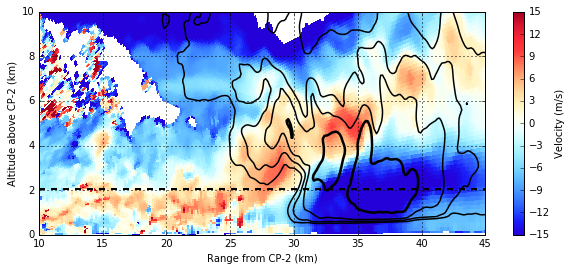

In [5]:
%matplotlib inline

"""
====================================================================
Create an RHI plot with reflectivity contour lines from an MDV file
====================================================================

An example which creates an RHI plot of velocity using a RadarDisplay object
and adding Reflectivity contours from the same MDV file.

"""
print __doc__
#libaries
import matplotlib.pyplot as plt
import pyart
import numpy as np
import scipy.ndimage as spyi
from scipy import ndimage
#config
root   = '/run/media/meso/DATA/phd/obs/radar/CP2/mdv/s_band/rhi/20141127/'
fn     = '054202.mdv'
sweep  = 1
fig_sz = [10, 4]
mask_min = -20
mask_max = 20
plt_min  = -15
plt_max  = 15
filt_sz  = 4
vel_cmap = 'pyart_BuDRd18'
x_lim    = [10, 45]
y_lim    = [0, 10]
levels   = np.arange(25, 55, 10)
#path
ffn  = root + fn

#setup figure
fig     = plt.figure(figsize=fig_sz)
ax      = fig.add_subplot(111)
#load file
radar   = pyart.io.read_mdv(ffn)
start   = radar.get_start(sweep)
end     = radar.get_end(sweep) + 1
display = pyart.graph.RadarDisplay(radar)

# gatefilter out extreme values
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('velocity',mask_min)
gatefilter.exclude_above('velocity',mask_max)
# correct for any folding
NI       = radar.instrument_parameters['nyquist_velocity']['data'][0]
corr_vel = pyart.correct.dealias_region_based(
        radar, vel_field='velocity', keep_original=False, 
        gatefilter = gatefilter, nyquist_vel=NI, centered = True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)
#apply median filtering to remove noise from sea breeze airmass
vel_data  = radar.fields['corrected_velocity']['data'][start:end]+1
flt_data  = ndimage.median_filter(vel_data, size = filt_sz)
flt_data  = np.ma.masked_where((flt_data >mask_max) | (flt_data < mask_min) , flt_data)
radar.fields['corrected_velocity']['data'][start:end] = flt_data
# plot velocity
display.plot('corrected_velocity', sweep=sweep, vmin=plt_min, vmax=plt_max, fig=fig,
             ax=ax, cmap=vel_cmap, colorbar_label='Velocity (m/s)',title='')
display.set_limits(xlim=x_lim, ylim=y_lim)

# extract reflectivity and coords
data = radar.fields['reflectivity']['data'][start:end]
x    = radar.gate_x['data'][start:end] / 1000.0 
y    = radar.gate_y['data'][start:end] / 1000.0
z    = radar.gate_z['data'][start:end] / 1000.0
# apply skips
data = data[10::,:]
x    = x[10::,:]
y    = y[10::,:]
z    = z[10::,:]
#use domain mask to remove refl noise in sea breeze
data[np.abs(x) < 6] = 0
#smooth reflectivity
data = spyi.gaussian_filter(data, sigma=1.2,mode='constant')
# calculate (R)ange
R = np.sqrt(x ** 2 + y ** 2) * np.sign(y) * np.sign(x)
# adds coutours to plot
ax.contour(R, z, data, levels, linewidths=1.5, colors='k',
                      linestyles='solid', antialiased=True)

ax.contour(R, z, data, [55], linewidths=2.5, colors='k',
                      linestyles='-', antialiased=True)

# adds contour labels (fmt= '%r' displays 10.0 vs 10.0000)
#plt.clabel(contours, levels, fmt='%u', inline=True, fontsize=10)

# format plot
# add grid (dotted lines, major axis only)
ax.grid(color='k', linestyle=':', linewidth=1, which='major')
ax.set_ylabel('Altitude above CP-2 (km)')
ax.set_xlabel('Range from CP-2 (km)')

# add LFC line
ax.axhline(2.06, 0, 1, linestyle='dashed', color='k', linewidth=2)
plt.savefig('rhi_20141127.png', dpi=200)
plt.show()